In [3]:
import sys,os,gzip
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
%load_ext sql


/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
sys.path.append(os.path.sep.join(os.path.split(os.getcwd())[:-1]))

In [5]:
import splitter

Our test set here includes the 1.3 million molecules from ChEMBL20 with MW < 600 that could be successfully processed by the RDKit.

We use the Standard InChI that comes with ChEMBL and a non-standard InChI (options "/FixedH /SUU") that allows tautomers to be distinguished. Here's the sequence of psql commands used to generate that set:
```
create temporary view molregno_lookup as select entity_id molregno,chembl_id from chembl_id_lookup where entity_type = 'COMPOUND';
select * into temporary table small_compounds from compound_structures join compound_properties using (molregno) where mw_freebase<600;
\f ' '
\a
\o chembl_export.txt 
select chembl_id,standard_inchi,standard_inchi_key,mol_inchi(m,'/FixedH /SUU') nonstandard_inchi, mol_inchikey(m,'/FixedH /SUU'), canonical_smiles from small_compounds join rdk.mols using (molregno) join molregno_lookup using(molregno) ;
```



In [7]:
%sql postgresql://localhost/inchi_split \
    select count(*) from chembl_export_nonstandard;

1 rows affected.


count
1332748


## Formula level grouping

In [9]:
d = %sql \
    select formula,count(chemblid) freq from chembl_export_nonstandard group by formula \
    order by freq desc limit 10;
d

10 rows affected.


formula,freq
/C20H20N2O3,404
/C20H22N2O2,399
/C19H18N2O3,384
/C18H16N2O3,378
/C20H22N2O3,357
/C19H20N2O2,352
/C18H18N2O2,352
/C21H22N2O3,351
/C21H23N3O3,347
/C18H20N2O3,347


## grouping on the main layer

In [11]:
d = %sql \
    select formula,skeleton,hydrogens,count(chemblid) freq from chembl_export_nonstandard group by \
    (formula,skeleton,hydrogens) \
    order by freq desc limit 10;

10 rows affected.


Look at a few of the common main layer groups

In [12]:
d[:5]

[('/C20H24N2O2', '/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18', '/h3-6,8,11,13-14,19-20,23H,1,7,9-10,12H2,2H3', 18),
 ('/C27H44O3', '/c1-18(8-6-14-26(3,4)30)23-12-13-24-20(9-7-15-27(23,24)5)10-11-21-16-22(28)17-25(29)19(21)2', '/h10-11,18,22-25,28-30H,2,6-9,12-17H2,1,3-5H3', 17),
 ('/C15H22O5', '/c1-8-4-5-11-9(2)12(16)17-13-15(11)10(8)6-7-14(3,18-13)19-20-15', '/h8-11,13H,4-7H2,1-3H3', 17),
 ('/C6H12O6', '/c7-1-2-3(8)4(9)5(10)6(11)12-2', '/h2-11H,1H2', 17),
 ('/C12H13NO4', '/c13-10(12(16)17)8-7(9(8)11(14)15)6-4-2-1-3-5-6', '/h1-5,7-10H,13H2,(H,14,15)(H,16,17)', 16)]

('/C20H24N2O2', '/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18', '/h3-6,8,11,13-14,19-20,23H,1,7,9-10,12H2,2H3')
18 rows affected.


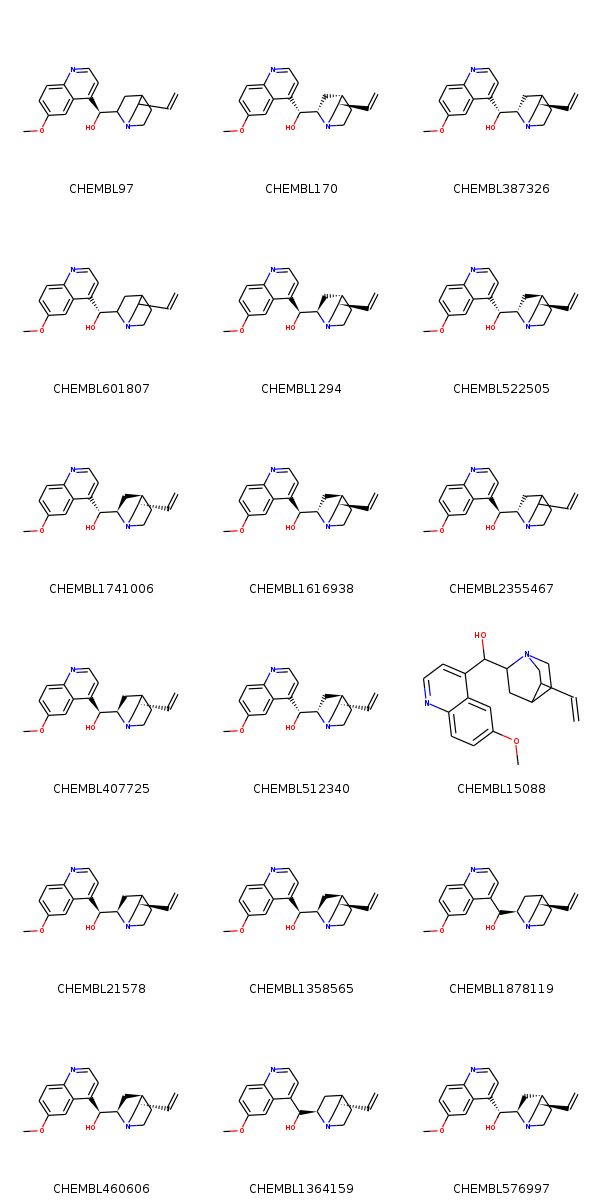

In [19]:
tpl=d[0][:-1]
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

('/C27H44O3', '/c1-18(8-6-14-26(3,4)30)23-12-13-24-20(9-7-15-27(23,24)5)10-11-21-16-22(28)17-25(29)19(21)2', '/h10-11,18,22-25,28-30H,2,6-9,12-17H2,1,3-5H3')
17 rows affected.


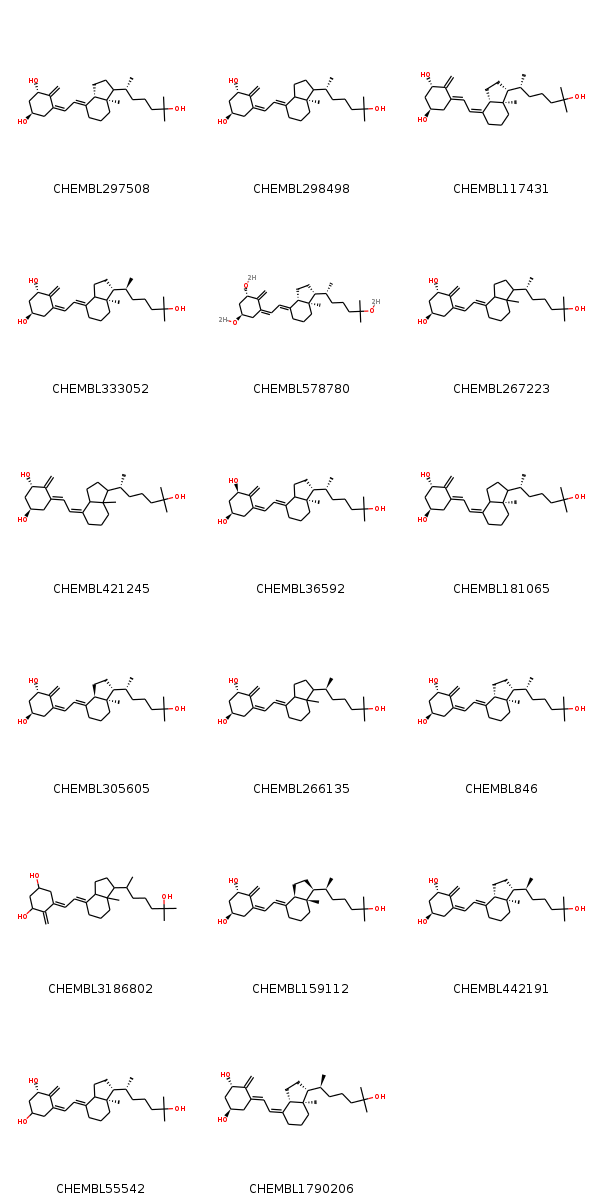

In [21]:
tpl=d[1][:-1]
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

('/C6H12O6', '/c7-1-2-3(8)4(9)5(10)6(11)12-2', '/h2-11H,1H2')
17 rows affected.


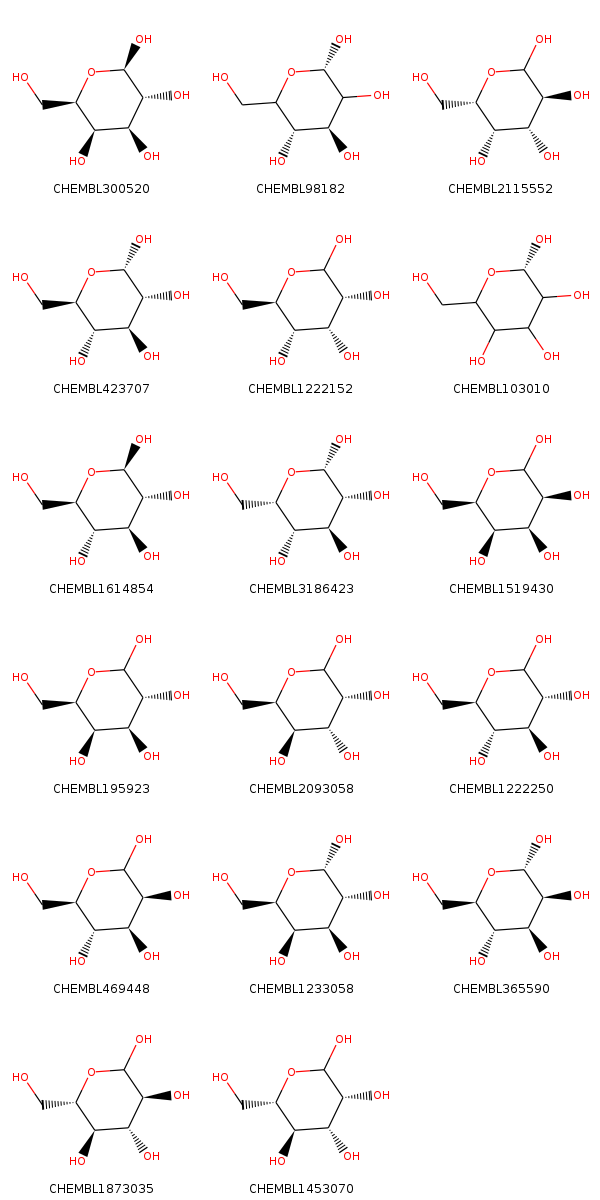

In [20]:
tpl=d[3][:-1]
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

## Charges

In [26]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,count(chemblid) freq from chembl_export_nonstandard group by \
    (formula,skeleton,hydrogens,charge,protonation) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C21H25ClO6', '/c1-2-27-15-6-3-12(4-7-15)9-14-10-13(5-8-16(14)22)21-20(26)19(25)18(24)17(11-23)28-21', '/h3-8,10,17-21,23-26H,2,9,11H2,1H3', None, None, None, '/t17-,18-,19+,20-,21+', '/m1', '/s1', 8),
 ('/C9H13N.H2O4S', '/c1-8(10)7-9-5-3-2-4-6-9;1-5(2,3)4', '/h2-6,8H,7,10H2,1H3;(H2,1,2,3,4)', None, None, None, '/t8?;', None, None, 7),
 ('/C31H43N3O8', '/c1-8-12-33-26-21-13-17(2)14-25(41-7)27(36)19(4)15-20(5)29(42-31(32)39)24(40-6)11-9-10-18(3)30(38)34-22(28(21)37)16-23(26)35', '/h8-11,15-17,19,24-25,27,29,33,36H,1,12-14H2,2-7H3,(H2,32,39)(H,34,38)', None, None, '/b11-9?,18-10?,20-15?', '/t17-,19+,24+,25+,27-,29+', '/m1', '/s1', 4),
 ('/C16H25NO2', '/c1-17(2)12-14-7-4-5-10-16(14,18)13-8-6-9-15(11-13)19-3', '/h6,8-9,11,14,18H,4-5,7,10,12H2,1-3H3', None, None, None, '/t14-,16+', '/m1', '/s1', 4),
 ('/C11H12N2S2', '/c1-15-11(14)13-7-8-6-12-10-5-3-2-4-9(8)10', '/h2-6,12H,7H2,1H3,(H,13,14)', None, None, None, None, None, None, 4)]

We saw those already

## Stereo grouping

In [27]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,stereo_bond,stereo_tet,stereo_m,stereo_s,count(chemblid) freq from chembl_export_nonstandard group by \
    (formula,skeleton,hydrogens,charge,protonation,stereo_bond,stereo_tet,stereo_m,stereo_s) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C21H25ClO6', '/c1-2-27-15-6-3-12(4-7-15)9-14-10-13(5-8-16(14)22)21-20(26)19(25)18(24)17(11-23)28-21', '/h3-8,10,17-21,23-26H,2,9,11H2,1H3', None, None, None, '/t17-,18-,19+,20-,21+', '/m1', '/s1', 8),
 ('/C9H13N.H2O4S', '/c1-8(10)7-9-5-3-2-4-6-9;1-5(2,3)4', '/h2-6,8H,7,10H2,1H3;(H2,1,2,3,4)', None, None, None, '/t8?;', None, None, 7),
 ('/C31H43N3O8', '/c1-8-12-33-26-21-13-17(2)14-25(41-7)27(36)19(4)15-20(5)29(42-31(32)39)24(40-6)11-9-10-18(3)30(38)34-22(28(21)37)16-23(26)35', '/h8-11,15-17,19,24-25,27,29,33,36H,1,12-14H2,2-7H3,(H2,32,39)(H,34,38)', None, None, '/b11-9?,18-10?,20-15?', '/t17-,19+,24+,25+,27-,29+', '/m1', '/s1', 4),
 ('/C16H25NO2', '/c1-17(2)12-14-7-4-5-10-16(14,18)13-8-6-9-15(11-13)19-3', '/h6,8-9,11,14,18H,4-5,7,10,12H2,1-3H3', None, None, None, '/t14-,16+', '/m1', '/s1', 4),
 ('/C11H12N2S2', '/c1-15-11(14)13-7-8-6-12-10-5-3-2-4-9(8)10', '/h2-6,12H,7H2,1H3,(H,13,14)', None, None, None, None, None, None, 4)]

('/C21H25ClO6', '/c1-2-27-15-6-3-12(4-7-15)9-14-10-13(5-8-16(14)22)21-20(26)19(25)18(24)17(11-23)28-21', '/h3-8,10,17-21,23-26H,2,9,11H2,1H3', '', '', '', '/t17-,18-,19+,20-,21+', '/m1', '/s1')
8 rows affected.


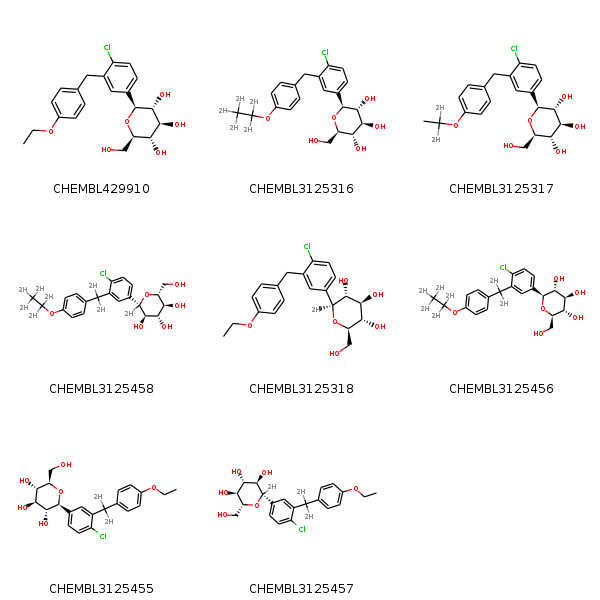

In [33]:
tpl=d[0][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,''),coalesce(stereo_bond,''),\
     coalesce(stereo_tet,''),coalesce(stereo_m,''),coalesce(stereo_s,'')) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

('/C16H25NO2', '/c1-17(2)12-14-7-4-5-10-16(14,18)13-8-6-9-15(11-13)19-3', '/h6,8-9,11,14,18H,4-5,7,10,12H2,1-3H3', '', '', '', '/t14-,16+', '/m1', '/s1')
4 rows affected.


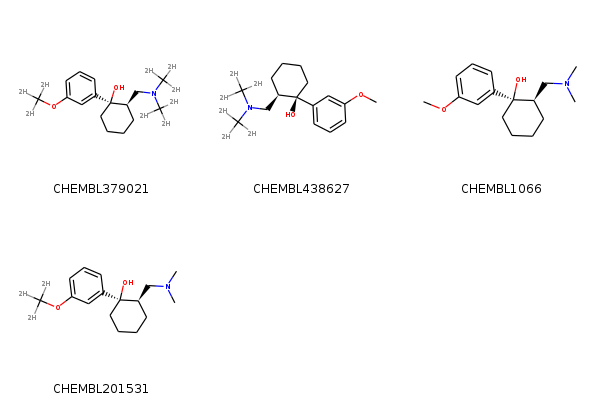

In [37]:
tpl=d[3][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,''),coalesce(stereo_bond,''),\
     coalesce(stereo_tet,''),coalesce(stereo_m,''),coalesce(stereo_s,'')) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

## Isotopes

In [45]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,isotope,count(chemblid) freq \
    from chembl_export_nonstandard  \
    group by \
    (formula,skeleton,hydrogens,charge,protonation,isotope) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C20H24N2O2', '/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18', '/h3-6,8,11,13-14,19-20,23H,1,7,9-10,12H2,2H3', None, None, None, 18),
 ('/C15H22O5', '/c1-8-4-5-11-9(2)12(16)17-13-15(11)10(8)6-7-14(3,18-13)19-20-15', '/h8-11,13H,4-7H2,1-3H3', None, None, None, 17),
 ('/C6H12O6', '/c7-1-2-3(8)4(9)5(10)6(11)12-2', '/h2-11H,1H2', None, None, None, 17),
 ('/C12H24O12S2', '/c13-1-5(15)10(19)11(20)12(24-26(21,22)23)7(17)4-25-3-6(16)9(18)8(25)2-14', '/h5-20H,1-4H2', None, None, None, 16),
 ('/C12H13NO4', '/c13-10(12(16)17)8-7(9(8)11(14)15)6-4-2-1-3-5-6', '/h1-5,7-10H,13H2,(H,14,15)(H,16,17)', None, None, None, 16)]

Those we've seen before at the skeleton grouping level. Let's see some that actually include isotope info:

In [58]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,isotope,count(chemblid) freq \
    from chembl_export_nonstandard where isotope is not null\
    group by \
    (formula,skeleton,hydrogens,charge,protonation,isotope) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C31H44F6O4', '/c1-27(2,40)14-4-7-21(9-6-16-29(41,30(32,33)34)31(35,36)37)25-12-13-26-22(8-5-15-28(25,26)3)11-10-20-17-23(38)19-24(39)18-20', '/h10-11,21,23-26,38-41H,4-5,7-9,12-15,17-19H2,1-3H3', None, None, '/i1D3,2D3', 4),
 ('/C20H27FN2O2', '/c1-4-22(5-2)20(24)14-8-6-9-15-18(14)19-16(23(15)13-12-21)10-7-11-17(19)25-3', '/h7,10-11,14H,4-6,8-9,12-13H2,1-3H3', None, None, '/i21-1', 3),
 ('/C23H18ClN5O2S', '/c24-19-10-8-18(9-11-19)22-21(17-4-2-1-3-5-17)15-29(27-22)23(26)28-32(30,31)20-12-6-16(14-25)7-13-20', '/h1-13,21H,15H2,(H2,26,28)', None, None, '/i14-1', 3),
 ('/C6H11FO5', '/c7-3-5(10)4(9)2(1-8)12-6(3)11', '/h2-6,8-11H,1H2', None, None, '/i7-1', 3),
 ('/C19H25ClFNO2', '/c1-12(10-21)24-19(23)18-16(14-4-6-15(20)7-5-14)9-13-3-8-17(18)22(2)11-13', '/h4-7,12-13,16-18H,3,8-11H2,1-2H3', None, None, '/i21-1', 3)]

('/C31H44F6O4', '/c1-27(2,40)14-4-7-21(9-6-16-29(41,30(32,33)34)31(35,36)37)25-12-13-26-22(8-5-15-28(25,26)3)11-10-20-17-23(38)19-24(39)18-20', '/h10-11,21,23-26,38-41H,4-5,7-9,12-15,17-19H2,1-3H3', '', '', '/i1D3,2D3')
4 rows affected.


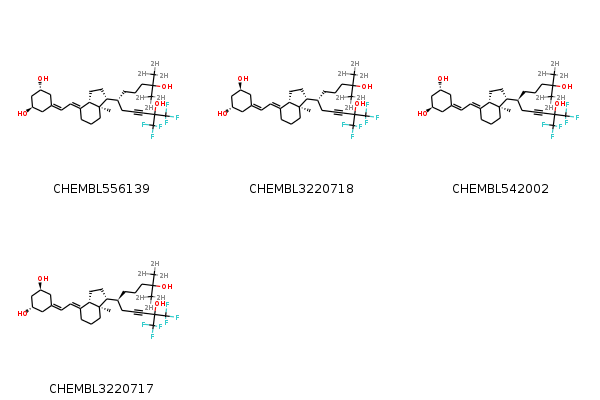

In [47]:
tpl=d[0][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,''),isotope) = :tpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

This is a good one to spend a bit of time with. Let's look at the other members of that family when we ignore isotopes (and just look at the main):

('/C31H44F6O4', '/c1-27(2,40)14-4-7-21(9-6-16-29(41,30(32,33)34)31(35,36)37)25-12-13-26-22(8-5-15-28(25,26)3)11-10-20-17-23(38)19-24(39)18-20', '/h10-11,21,23-26,38-41H,4-5,7-9,12-15,17-19H2,1-3H3', '', '')
6 rows affected.


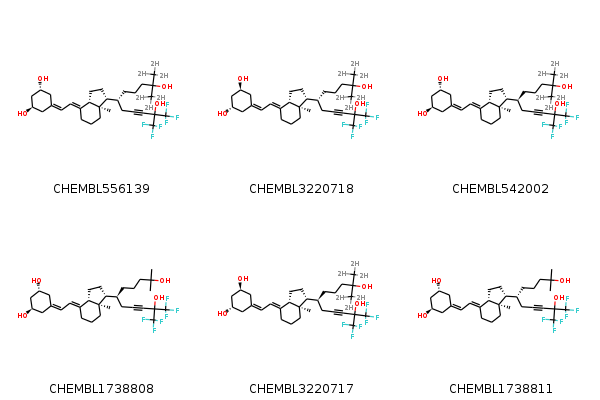

In [48]:
ttpl = tpl[:-1]
print(ttpl)
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,'')) = :ttpl
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

## Find cases where the isotope causes the stereochemistry

### tetrahedral stereochem

In [59]:
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
     isotope_stereo_tet is not null and stereo_tet!=isotope_stereo_tet 
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
len(rows)

34 rows affected.


34

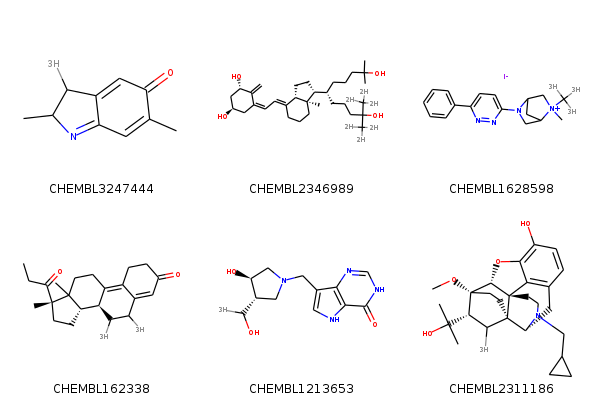

In [53]:
Draw.MolsToGridImage(ms[:6],legends=cids)

Most of those have the labelled atom involved in an unknown stereocenter (the second is the exception), see if we can find more of those:

In [60]:
rows = %sql \
  select chemblid,smiles from chembl_export join chembl_export_nonstandard using (chemblid) where \
     isotope_stereo_tet is not null and position('?' in isotope_stereo_tet)<=0 and stereo_tet!=isotope_stereo_tet 
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
len(rows)

9 rows affected.


9

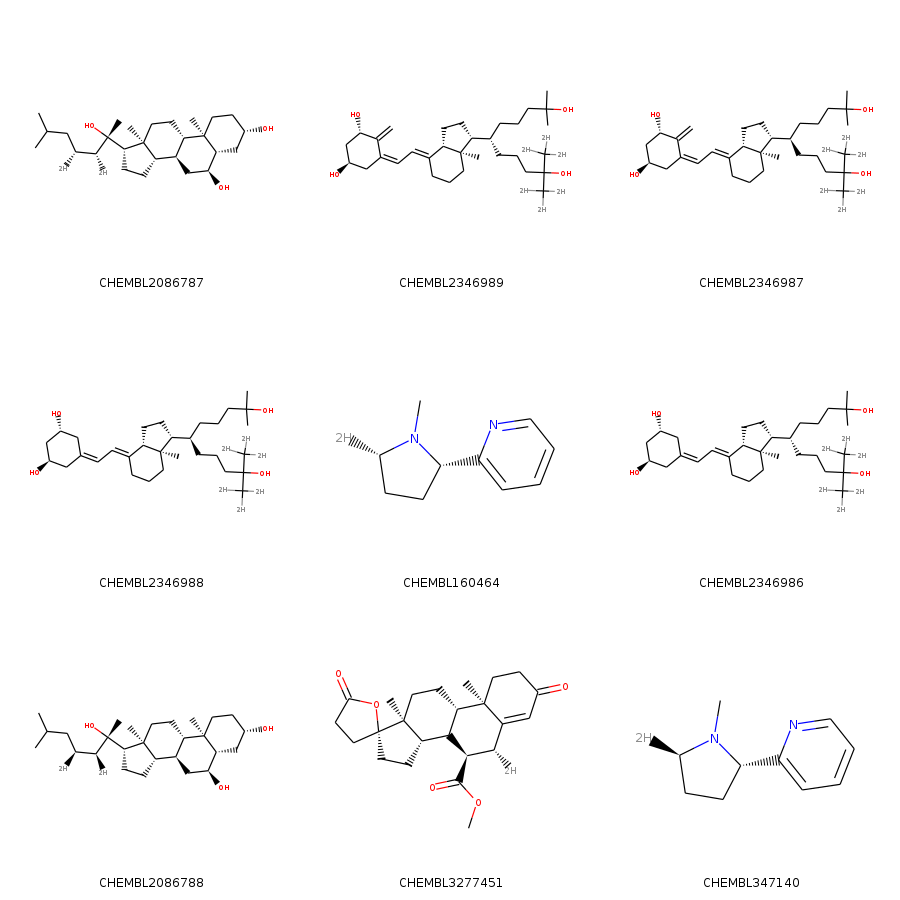

In [61]:
Draw.MolsToGridImage(ms,legends=cids,subImgSize=(300,300))

In [49]:
smis[tItems[-2][1]]

'[2H][C@@H]1[C@H]([C@@H]2[C@H](CC[C@@]3(C)[C@H]2CC[C@@]34CCC(=O)O4)[C@@]5(C)CCC(=O)C=C15)C(=O)OC'